<a href="https://colab.research.google.com/github/pawanbhatta178/FakeReviewDetector/blob/main/ReviewAIDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 ### Problem Statement

User generated reviews for products has been a cornerstone for people’s interest in purchase.
However, the rise of the Large Language Model (LLM) has made generating these reviews
inexpensive, quick and trivial. This means the usage of LLM to generate fake reviews is on the
rise. The goal of this project is to build and explore different strategies for the classification
problems at hand: Statistical (Simple), Supervised Transformer based, and Self detection using
LLM. First one is based on statistical differences of the text generated by LLM as compared to
humans, with respect to attributes like token distribution and entropy and perplexity. This is
based on the notion that human generated text usually has higher perplexity than AI generated.
We plan to also experiment with the second approach where we fine tune transformer based
models to do the classification task. We compare the performances of above-mentioned
approaches. For the final strategy, we prompt LLM to self detect if the given text is generated by
AI or not.


### Data acquisition

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Dataset 1:  [Ai vs Human](https://www.kaggle.com/datasets/shanegerami/ai-vs-human-text?resource=download)

This dataset consist of laballed human and AI generated essays.

##### Getting the dataset

Make sure to download the ai vs human  zip file from [kaggle](https://www.kaggle.com/datasets/shanegerami/ai-vs-human-text?resource=download), unzip it and upload a copy of AI_Human csv in google drive. Make sure to create the exact directory structure as in `csv_path` so all contributors can work with same version of this code.

In [21]:
import pandas as pd

csv_path = '/content/drive/MyDrive/Grad/NLP/FinalProject/AI_Human.csv'
df = pd.read_csv(csv_path)

df.info()     # column names + dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487235 entries, 0 to 487234
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   text       487235 non-null  object 
 1   generated  487235 non-null  float64
dtypes: float64(1), object(1)
memory usage: 7.4+ MB


##### AI Generated Texts

In [22]:
df_ai=df[df['generated']==1]
df_ai.info()
# df_ai.head()


<class 'pandas.core.frame.DataFrame'>
Index: 181438 entries, 704 to 487232
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   text       181438 non-null  object 
 1   generated  181438 non-null  float64
dtypes: float64(1), object(1)
memory usage: 4.2+ MB


In [23]:
df_ai.head(10)

,text,generated
704,"This essay will analyze, discuss and prove one...",1.0
740,I strongly believe that the Electoral College ...,1.0
1262,"Limiting car use causes pollution, increases c...",1.0
1378,Car-free cities have become a subject of incre...,1.0
1379,"Car Free Cities Car-free cities, a concept ga...",1.0
1380,A Sustainable Urban Future Car-free cities ...,1.0
1381,Pioneering Sustainable Urban Living In an e...,1.0
1382,The Path to Sustainable Urban Living In an ...,1.0
1383,A Paradigm Shift in Urban Living In an era ...,1.0
1384,Revolutionizing Urban Living In an age defi...,1.0


##### Human Generated Texts

In [24]:
df_human=df[df['generated']==0]
df_human.info()

<class 'pandas.core.frame.DataFrame'>
Index: 305797 entries, 0 to 487234
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   text       305797 non-null  object 
 1   generated  305797 non-null  float64
dtypes: float64(1), object(1)
memory usage: 7.0+ MB


In [25]:
df_human.head(10)

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0
5,The electrol college system is an unfair syste...,0.0
6,"Dear state senator, It is the utmost respect t...",0.0
7,"Fellow citizens, cars have become a major role...",0.0
8,"""It's official: The electoral college is unfai...",0.0
9,The Electoral College has been kept for centur...,0.0


### Installing Libraries for Model Pretraining

In [7]:
!pip install -q datasets
!pip install -q transformers



### Classifier based on Perplexity from Pretrained GPT 2 Model

First we analyse if the out plan to use perplexity looks promising. We run pretrained GPT model and calculated perplexity on our dataset. Analyze if indeed perplexity is different for human vs AI generated text.

#### Run Pretrained GPT2 Model

In [9]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
import math

def load_model_and_tokenizer(model_name='gpt2', device=None):
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    model = GPT2LMHeadModel.from_pretrained(model_name)
    model.eval()
    model.to(device)

    return tokenizer, model

In [10]:
tokenizer, model= load_model_and_tokenizer('gpt2-medium')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

#### Calculate perplexity

We select 200 texts from AI generated and 200 from human written for this purpose. We call this `REVIEW_COUNT_PER_CATEGORY`

In [28]:
REVIEW_COUNT_PER_CATEGORY = 200

In [11]:
def calculate_perplexity(sentence, max_length=1024):
    inputs = tokenizer(sentence, return_tensors='pt',truncation=True, max_length=max_length)
    input_ids = inputs['input_ids']

    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids) # labels helps to compute loss
        loss = outputs.loss
        # print(outputs.logits)
        perplexity = torch.exp(loss)

    return perplexity.item()


In [12]:
calculate_perplexity("hey what's up?")

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


70.79589080810547

In [13]:
from tqdm import tqdm

# List to store perplexities
perplexities = []

# Loop through the first REVIEW_COUNT_PER_CATEGORY sentences
for i in tqdm(range(REVIEW_COUNT_PER_CATEGORY)):
    sentence = df_ai.iloc[i]['text']
    ppl = calculate_perplexity(sentence)
    perplexities.append(ppl)

# Print the list of perplexities
print(perplexities)

100%|██████████| 200/200 [06:33<00:00,  1.97s/it]

[12.034640312194824, 7.010541915893555, 43.2188835144043, 8.453803062438965, 9.360954284667969, 10.115002632141113, 10.454500198364258, 10.412582397460938, 10.176542282104492, 10.766554832458496, 10.338016510009766, 10.79175090789795, 11.221626281738281, 11.422006607055664, 10.389768600463867, 10.66109561920166, 10.434738159179688, 10.770413398742676, 10.82451057434082, 11.624955177307129, 10.307821273803711, 10.507919311523438, 10.638200759887695, 10.521464347839355, 10.690590858459473, 10.317980766296387, 10.643891334533691, 10.383277893066406, 10.111650466918945, 10.646101951599121, 10.4682035446167, 10.457980155944824, 10.357867240905762, 10.35878849029541, 10.380864143371582, 10.55555248260498, 10.343890190124512, 10.378499031066895, 10.775666236877441, 10.502935409545898, 10.398758888244629, 10.375069618225098, 10.315004348754883, 10.478436470031738, 10.552897453308105, 10.54003620147705, 10.432099342346191, 10.566883087158203, 10.499750137329102, 8.97367000579834, 7.765793323516

In [14]:
from tqdm import tqdm

# List to store perplexities
perplexities_human = []

# Loop through the first REVIEW_COUNT_PER_CATEGORY sentences
for i in tqdm(range(REVIEW_COUNT_PER_CATEGORY)):
    sentence = df_human.iloc[i]['text']
    ppl = calculate_perplexity(sentence)
    perplexities_human.append(ppl)

# Print the list of perplexities
print(perplexities_human)

100%|██████████| 200/200 [07:22<00:00,  2.21s/it]

[26.627029418945312, 29.806535720825195, 29.418527603149414, 29.285886764526367, 35.482574462890625, 32.35762023925781, 24.495336532592773, 28.80390739440918, 25.19346046447754, 23.43231201171875, 25.838197708129883, 23.094947814941406, 14.076231002807617, 23.919918060302734, 26.18849754333496, 22.367969512939453, 22.704532623291016, 46.50752639770508, 20.522186279296875, 28.473587036132812, 17.461013793945312, 43.33000183105469, 30.309158325195312, 16.050418853759766, 15.902042388916016, 15.816094398498535, 19.345726013183594, 25.47486114501953, 20.0647029876709, 32.88892364501953, 19.665340423583984, 21.655488967895508, 13.162854194641113, 57.799224853515625, 16.72652244567871, 25.444934844970703, 25.743473052978516, 23.608741760253906, 28.908660888671875, 13.548873901367188, 34.53145217895508, 23.179534912109375, 19.250883102416992, 12.48000717163086, 26.514799118041992, 42.6022834777832, 35.428382873535156, 13.901856422424316, 19.924118041992188, 25.149356842041016, 37.940296173095

#### Perplexity Distribution Visualizations

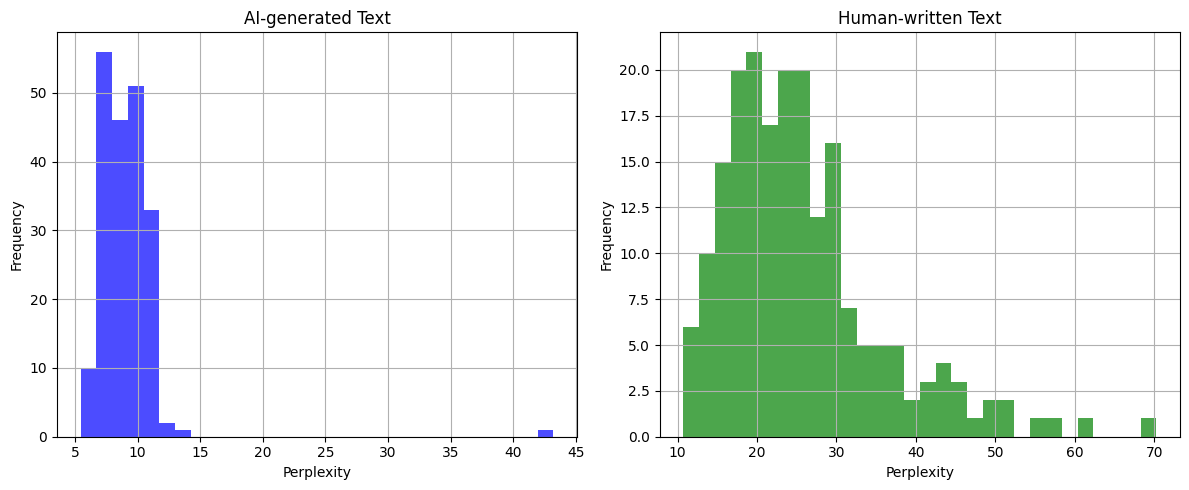

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# AI-generated
plt.subplot(1, 2, 1)
plt.hist(perplexities, bins=30, color='blue', alpha=0.7)
plt.title('AI-generated Text')
plt.xlabel('Perplexity')
plt.ylabel('Frequency')
plt.grid(True)

# Human-written
plt.subplot(1, 2, 2)
plt.hist(perplexities_human, bins=30, color='green', alpha=0.7)
plt.title('Human-written Text')
plt.xlabel('Perplexity')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()


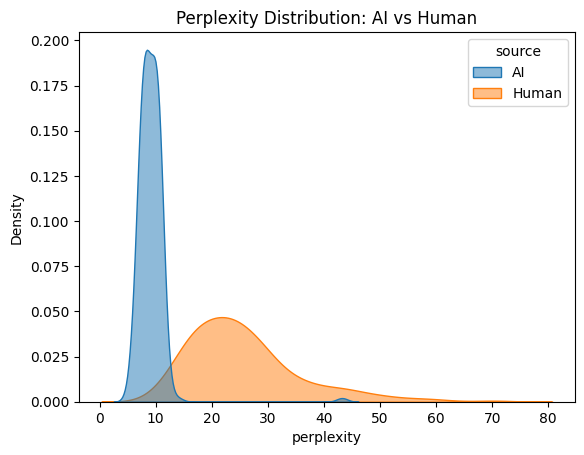

In [16]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame({
    'perplexity': perplexities + perplexities_human,
    'source': ['AI'] * len(perplexities) + ['Human'] * len(perplexities_human)
})

sns.kdeplot(data=df, x='perplexity', hue='source', fill=True, common_norm=False, alpha=0.5)
plt.title("Perplexity Distribution: AI vs Human")
plt.show()


The KDE graph is very promising that leads us to create classifier just based on perplexity.

#### Dataset preparation for Classifier

We put together the perplexities calculated so far and create a balanced dataset for our Logistic Regression classifier.

In [26]:
# Add perplexity column to both DataFrames
df_human2 = df_human.iloc[:REVIEW_COUNT_PER_CATEGORY].copy()
df_human2['perplexity'] = perplexities_human
df_human2['label'] = 0


df_ai2 = df_ai.iloc[:REVIEW_COUNT_PER_CATEGORY].copy()
df_ai2['perplexity'] = perplexities
df_ai2['label'] = 1  # mark as AI-generated

# Combine the DataFrames
df_combined = pd.concat([df_human2, df_ai2], ignore_index=True)

# Optional: Shuffle the combined DataFrame
df_combined = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

# View the result
print(df_combined.head())

                                                text  generated  perplexity  \
0    Revolutionizing Urban Living  In an age defi...        1.0   10.766555   
1  In recent years, there has been a growing move...        1.0    7.874869   
2  The Electoral College is a very useful and eas...        0.0   57.799225   
3    Pioneering Sustainable Urban Living  In an a...        1.0   10.338017   
4  Dear senator, the Electoral College has always...        0.0   16.707506   

   label  
0      1  
1      1  
2      0  
3      1  
4      0  


#### Logistic Regression Using Perplexity as feature

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96        42
           1       0.95      0.97      0.96        38

    accuracy                           0.96        80
   macro avg       0.96      0.96      0.96        80
weighted avg       0.96      0.96      0.96        80

AUC Score: 0.9724310776942355


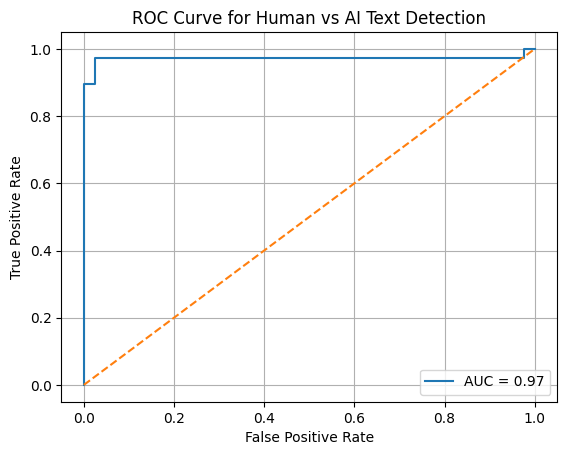

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Define features and labels
X = df_combined[['perplexity']]  # Only perplexity as feature
y = df_combined['label']         # 1 = human, 0 = AI

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Train logistic regression model
clf = LogisticRegression()
clf.fit(X_train, y_train)

# 4. Predict
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]  # Probability that label = 1 (human)

# 5. Evaluate model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_prob))

# 6. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Human vs AI Text Detection")
plt.legend()
plt.grid()
plt.show()


### BERT Model

In [ ]:
# Import libraries
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128
    )


In [ ]:
# Stratified 20k sample
df_sampled, _ = train_test_split(
    df,
    train_size=30000,
    stratify=df['generated'],
    random_state=42
)

# Confirm class balance
print(df_sampled['generated'].value_counts(normalize=True))


generated
0.0    0.627633
1.0    0.372367
Name: proportion, dtype: float64


In [ ]:
# 80/20 split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_sampled['text'], df_sampled['generated'],
    test_size=0.2,
    random_state=42
)


In [ ]:
# Convert to Hugging Face datasets
train_dataset = Dataset.from_dict({'text': train_texts, 'label': train_labels})
val_dataset = Dataset.from_dict({'text': val_texts, 'label': val_labels})

# Tokenize with multiprocessing
train_dataset = train_dataset.map(tokenize_function, batched=True, num_proc=4)
val_dataset = val_dataset.map(tokenize_function, batched=True, num_proc=4)

Map (num_proc=4):   0%|          | 0/24000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/6000 [00:00<?, ? examples/s]

In [ ]:
# Load pre-trained BERT model with classification head
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    save_strategy='epoch',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=10,
    load_best_model_at_end=True
)
# Set up Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer.train()


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pawanbhatta178 (pawanbhatta178-asdsd) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


ValueError: Target size (torch.Size([16])) must be the same as input size (torch.Size([16, 2]))